In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import PIL.Image as Image
import torchvision
import torch.nn as nn
import torch.optim as optim
import sys
from captum.attr import GuidedGradCam
import cv2
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz

sys.path.insert(0, '../src')
from bird_dataset import *
from XAI_birds_dataloader import *

In [21]:
# https://gilberttanner.com/blog/interpreting-pytorch-models-with-captum

In [22]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [23]:
bd = BirdDataset()

In [24]:
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_bird_dataset = XAI_Birds_Dataset(bd, transform=trans, train=True)
val_bird_dataset = XAI_Birds_Dataset(bd, transform=trans, train=False, val=True)

model = models.vgg16_bn(pretrained=False)
num_feats = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(num_feats, len(train_bird_dataset.class_dict))])
model.classifier = nn.Sequential(*features) # Replace the model classifier

In [25]:
model.load_state_dict(torch.load('../models/transfer_vgg16_31_class_5_epoch_4_batch.pth'))

<All keys matched successfully>

In [26]:
model.eval()
# batch_size = 4
trainloader = DataLoader(train_bird_dataset)
valloader = DataLoader(val_bird_dataset)

In [27]:
if torch.cuda.is_available():
    model.cuda()

In [28]:
def gradCAM_model(model, idx, model_name):
        last_conv = model.features[40]
        gc = GuidedGradCam(model, last_conv)
        samp = val_bird_dataset[idx]
        # samp = iter(valloader).next()
        img, label = samp['image'].cuda(), samp['label'].cuda()
        img = img.expand((1, 3, 224, 224))

        gc_img = gc.attribute(img, label)

        # create custom colormap for visualizing the result
        default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                         [(0, '#ffffff'),
                                                          (0.25, '#000000'),
                                                          (1, '#000000')], N=256)


        # visualize the results using the visualize_image_attr helper method
        x = viz.visualize_image_attr_multiple(np.transpose(gc_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                     np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                     methods=["original_image", "heat_map"],
                                     signs=['all', 'positive'],
                                     cmap=default_cmap,
                                     show_colorbar=True)
        x[0].savefig(f'../figures/grad_cam_{model_name}_{idx}.png')

In [17]:
np.random.choice(range(len(val_bird_dataset)))

313

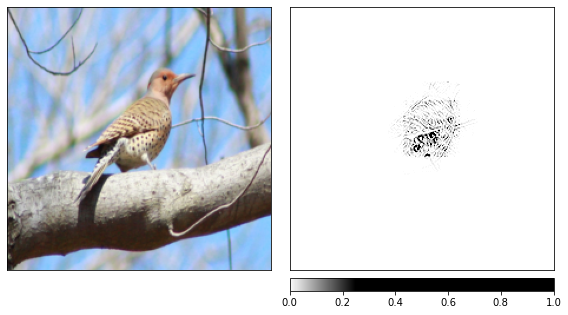

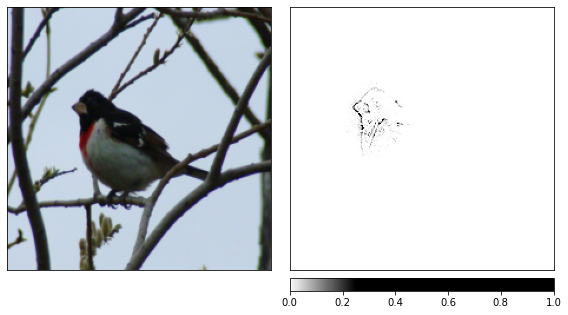

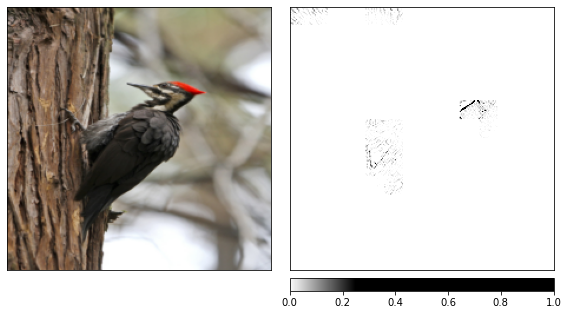

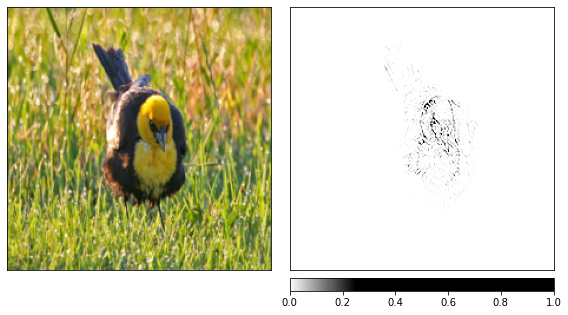

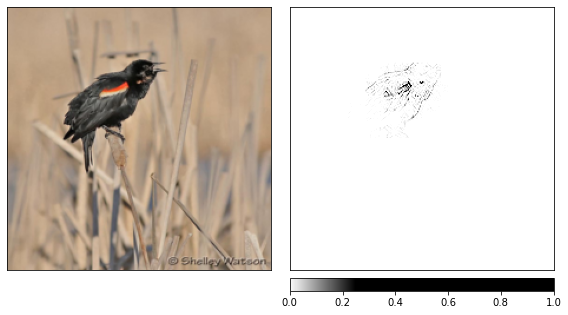

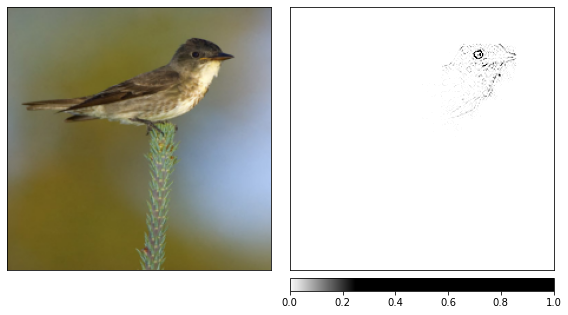

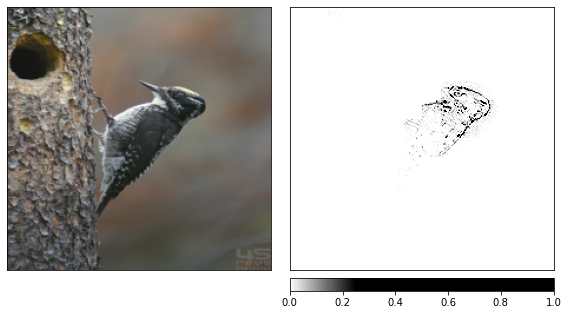

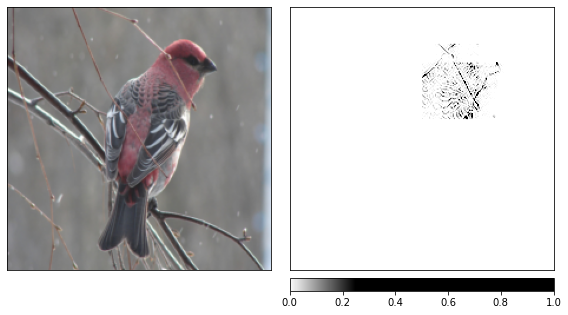

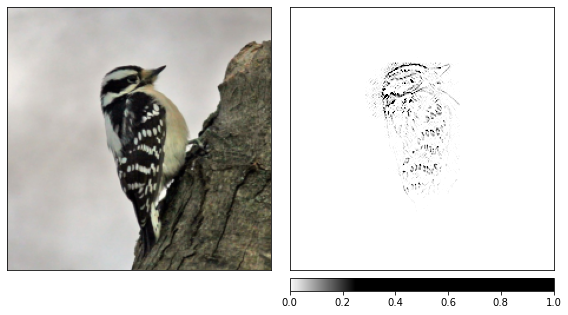

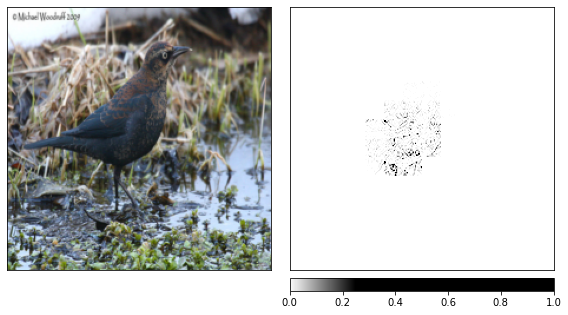

In [29]:
for i in range(10):
    gradCAM_model(model, np.random.choice(range(len(val_bird_dataset))), 'species')